# TensorFlow2教程-使用keras训练模型

本指南包含了TensorFlow 2.0中在以下两种情况下的训练，评估和预测（推理）模型：

- 使用内置的训练和评估API（例如model.fit()，model.evaluate()，model.predict()）。
- 使用eager execution 和GradientTape对象从头开始编写自定义循环。

无论是使用内置循环还是编写自己的循环，模型和评估训练在每种Keras模型中严格按照相同的方式工作，无论是Sequential 模型, 函数式 API, 还是模型子类化。

In [1]:
# !pip install -q pydot
# !apt-get install graphviz

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

/home/doit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 一般的模型构造、训练、测试流程
使用内置的训练和评估API对模型进行训练和验证。

In [13]:
# 模型构造
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

端到端的模型训练。

In [14]:
# 载入数据
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

# 保证还是float 32？ 否则后面会出现：TypeError: Input 'y' of 'Sub' Op has type float32 that does not match type uint8 of argument 'x'.
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')



# 取验证数据
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

# 训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=3,
         validation_data=(x_val, y_val))
print('history:')
print(history.history)

result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)
pred = model.predict(x_test[:2])
print('predict:')
print(pred)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 40us/sample - loss: 0.3406 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.1747 - val_sparse_categorical_accuracy: 0.9478
Epoch 2/3
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1562 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.1353 - val_sparse_categorical_accuracy: 0.9605
Epoch 3/3
50000/50000 [==============================] - 2s 34us/sample - loss: 0.1142 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.1093 - val_sparse_categorical_accuracy: 0.9670
history:
{'loss': [0.3406039907693863, 0.1561644163942337, 0.11421714420557022], 'sparse_categorical_accuracy': [0.90378, 0.95214, 0.96466], 'val_loss': [0.17468911408782006, 0.13526522952914238, 0.10934125750362873], 'val_sparse_categorical_accuracy': [0.9478, 0.9605, 0.967]}
10000/1 [=========================================================================================================

evaluate:
[0.11812290600538254, 0.9643]
predict:
[[5.96028303e-06 1.22943675e-06 5.60810586e-05 4.95154876e-03
  3.37098766e-10 1.87345813e-05 1.95063844e-11 9.94938374e-01
  3.62650326e-06 2.44577204e-05]
 [9.77753075e-07 1.13667054e-04 9.99821007e-01 5.17880726e-05
  1.29938716e-11 9.91447632e-06 3.67613637e-07 2.29428121e-08
  2.27706096e-06 1.34117118e-11]]


## 2 自定义指标和损失

### 2.1 配置网络
在对模型训练之前，我们需要指定损失函数，优化器以及可选的一些要监控的指标。我们将这些配置参数作为compile()方法的参数传递给模型，对模型进行配置。

In [15]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

TensorFlow2提供许多内置的优化器，损失和指标
常见的内置参数如下：

- 优化器： - SGD()（有或没有动量） - RMSprop() - Adam() -等等。

- 损失： - MeanSquaredError() - KLDivergence() - CosineSimilarity() -等等。

- 指标： - AUC() - Precision() - Recall() -等等。

### 2.2 自定义损失
用Keras提供两种方式来提供自定义损失。
- 一、例创建一个接受输入y_true和的函数y_pred。
- 二、构建一个继承keras.losser.Loss的子类
下面示例显示了一个损失函数，该函数计算实际数据与预测之间的平均距离：

In [16]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name='digits')
    x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
model = get_uncompiled_model()

def basic_loss_function(y_true, y_pred):
    return tf.math.reduce_mean(y_true - y_pred)
model.compile(optimizer=keras.optimizers.Adam(),
              loss=basic_loss_function)
model.fit(x_train, y_train, batch_size=64, epochs=3)


Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 1s 28us/sample - loss: 4.3488
Epoch 2/3
50000/50000 [==============================] - 1s 24us/sample - loss: 4.3488
Epoch 3/3
50000/50000 [==============================] - 1s 25us/sample - loss: 4.3488


如果需要试下带参数的损失函数，可以子类化tf.keras.losses.Loss。并子类化以下方法：
- \__init\__(self)  接收相关参数，初始化loss之类。
- call(self, y_true, y_pred)  使用 y_true和y_pred，计算模型损失。

下面例子，展示了WeightedCrossEntropy计算二分损失的损失函数，某个类或整个函数的损失可以通过标量修改。

In [17]:
class WeightBinaryCrossEntropy(keras.losses.Loss):
    def __init__(self, pos_weight, weight, from_logits=False,
                reduction=keras.losses.Reduction.AUTO,
                name='weight_binary_crossentropy'):
        """
        pos_weight: 正类标签权重
        weight: 整体损失权重
        from_logits: 是否使用logits来计算loss，（或使用probability）
        reduction: reduction类型
        name: 名字
        """
        super(WeightBinaryCrossEntropy, self).__init__(reduction=reduction,
                                                      name=name)
        self.pos_weight = pos_weight
        self.weight = weight
        self.from_logits = from_logits
        
    def call(self, y_true, y_pred):
        if not self.from_logits:
            x_1 = y_true * self.pos_weight * -tf.math.log(y_pred + 1e-6)
            
            x_2 = (1-y_true) * -tf.math.log(1-y_pred + 1e-6)
            
            return tf.add(x_1, x_2) * self.weight
        
        return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.pos_weight) *self.weight
        

model.compile(optimizer=keras.optimizers.Adam(),
             loss=WeightBinaryCrossEntropy(0.5, 2))
model.fit(x_train, y_train, batch_size=64, epochs=3)
        

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 35us/sample - loss: 9.5178
Epoch 2/3
50000/50000 [==============================] - 1s 27us/sample - loss: 9.5171
Epoch 3/3
50000/50000 [==============================] - 1s 27us/sample - loss: 9.5171


使用网络层的方法构建loss

In [18]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs)* 0.1)
        return inputs
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# 添加计算正则化损失的层
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy')

# 训练
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 2s 36us/sample - loss: 2.4702


### 2.3 自定义指标

自定义指标只需继承Metric类， 并重写以下函数：

- \__init\__(self)，初始化。

- update_state(self，y_true，y_pred，sample_weight = None)，它使用目标y_true和模型预测y_pred来更新状态变量。

- result(self)，它使用状态变量来计算最终结果。

- reset_states(self)，重新初始化度量的状态。

状态更新和结果计算保持分开（分别在update_state()和result()中），因为在某些情况下，结果计算可能非常昂贵，并且只能定期进行。

In [6]:
# 下面是一个简单的示例，显示如何实现CatgoricalTruePositives指标，该指标计算正确分类为属于给定类的样本数量

class CatgoricalTruePostives(keras.metrics.Metric):
    def __init__(self, name='binary_true_postives', **kwargs):
        super(CatgoricalTruePostives, self).__init__(name=name, **kwargs)
        # 会更新的类变量
        self.true_postives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # 获取结果id
        y_pred = tf.argmax(y_pred)
        # 正确的结果
        y_true = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
        y_true = tf.cast(y_true, tf.float32)
        
        if sample_weight is not None:
            # 对正确结果加权重
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = tf.multiply(sample_weight, y_true)
        # 修改正确样本总量
        return self.true_postives.assign_add(tf.reduce_sum(y_true))
    
    def result(self):
        # 返回相应tensor
        return tf.identity(self.true_postives)
    
    def reset_states(self):
        # 重置为0
        self.true_postives.assign(0.)
        

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[CatgoricalTruePostives()])

model.fit(x_train, y_train,
         batch_size=64, epochs=3)
            
            
            

Epoch 1/3
50000/50000 [==============================] - 1s 27us/sample - loss: 0.0590 - binary_true_postives: 9186.0000
Epoch 2/3
50000/50000 [==============================] - 1s 24us/sample - loss: 0.0499 - binary_true_postives: 9957.0000
Epoch 3/3
50000/50000 [==============================] - 1s 25us/sample - loss: 0.0441 - binary_true_postives: 10939.0000


使用自定义层的方式获取相关指标

In [5]:
# 也可以以定义网络层的方式添加要统计的metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # 该层的作用就是添加指标
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        # 直接把输入进行输出
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
# 直接套在对应的网络层中
h1 = MetricLoggingLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)
# 配置并训练网络
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 2s 41us/sample - loss: 0.2940 - sparse_categorical_accuracy: 0.9151 - std_of_activation: 0.9423


我们也可以在构建好模型后直接使用，model.add_loss和model.add_metric添加损失和指标。

In [20]:
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs, outputs)
# 直接把计算loss或metric用到的输入(h1)带人
model.add_metric(keras.backend.std(h1),
                       name='std_of_activation',
                       aggregation='mean')

model.add_loss(tf.reduce_sum(h1)*0.1)

# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 81us/sample - loss: 2.3469 - sparse_categorical_accuracy: 0.1130 - std_of_activation: 0.0010


处理使用validation_data传入测试数据，还可以使用validation_split划分验证数据

ps:validation_split只能在用numpy数据训练的情况下使用

In [21]:


model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 79us/sample - loss: 2.3014 - sparse_categorical_accuracy: 0.1141 - std_of_activation: 3.6019e-06 - val_loss: 2.3013 - val_sparse_categorical_accuracy: 0.1115 - val_std_of_activation: 1.2214e-06


## 3 使用tf.data构造数据

到现在我们已经了解了如何使用使用numpy作为输入数据进行训练和验证。下面，我们将介绍如何使用tf.data作为输入数据进行。

In [22]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model
model = get_compiled_model()
# 构建dataset实例
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# 打乱
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
# 获得验证数据
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
model.fit(train_dataset, epochs=3, steps_per_epoch=100,
         validation_data=val_dataset, validation_steps=3)



Train for 100 steps, validate for 3 steps
Epoch 1/3
100/100 [==============================] - 1s 15ms/step - loss: 0.8740 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.4562 - val_sparse_categorical_accuracy: 0.8802
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3867 - sparse_categorical_accuracy: 0.8891 - val_loss: 0.3228 - val_sparse_categorical_accuracy: 0.8958
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3206 - sparse_categorical_accuracy: 0.9095 - val_loss: 0.2346 - val_sparse_categorical_accuracy: 0.9323


如果只想对该数据集中的特定批次进行训练，则可以传递steps_per_epoch参数，即批训练多少步。同样我们可以使用train_dataset.take(), 来获取每批次中训练的数据，其和steps_per_epoc等价。

In [24]:
model = get_compiled_model()

model.fit(train_dataset.take(100), epochs=3)

Epoch 1/3
100/100 [==============================] - 2s 17ms/step - loss: 0.7795 - sparse_categorical_accuracy: 0.7961
Epoch 2/3
100/100 [==============================] - 1s 5ms/step - loss: 0.3308 - sparse_categorical_accuracy: 0.9080
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.2465 - sparse_categorical_accuracy: 0.9308


In [23]:
# 模型测试
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

print('\n# Evaluate')
model.evaluate(test_dataset)


# Evaluate
157/157 [==============================] - 0s 1ms/step - loss: 0.2669 - sparse_categorical_accuracy: 0.9243


[0.2669110751835404, 0.9243]

**其他格式输入数据支持**

除了numpy数值和TensorFlow Dataset,还可以用Pandas和python迭代器作为数据输入。
通常小数据推荐使用numpy， 大数据推荐使用TensorFlow Dataset。

## 4 样本权重和类权重
在模型训练时可以，可以人工设定样本权重和类权重。

“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常用于不平衡的分类问题（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是1和0时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重”dict是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，如果类“0”比数据中的类“1”少两倍，则可以使用class_weight = {0：1.，1：0.5}。

添加方法：
- 使用Numpy数据时： 通过sample_weight和class_weight参数传递。
- 使用Dataset数据时： 通过使数据集返回(input_batch, target_batch, sample_weight_batch)。

下面是一个Numpy数据中加大第5类的权重的例子。

In [25]:
# 增加第5类的权重
import numpy as np
# 类权重
model = get_compiled_model()
class_weight = {i:1.0 for i in range(10)}
# 第5类的权重为2
class_weight[5] = 2.0
print(class_weight)
model.fit(x_train, y_train,
         class_weight=class_weight,
         batch_size=64,
         epochs=4)
# 样本权重
model = get_compiled_model()
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
model.fit(x_train, y_train,
         sample_weight=sample_weight,
         batch_size=64,
         epochs=4)


{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 2s 49us/sample - loss: 0.3598 - sparse_categorical_accuracy: 0.9047
Epoch 2/4
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1603 - sparse_categorical_accuracy: 0.9545
Epoch 3/4
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1172 - sparse_categorical_accuracy: 0.9666
Epoch 4/4
50000/50000 [==============================] - 2s 32us/sample - loss: 0.0940 - sparse_categorical_accuracy: 0.9738
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 2s 42us/sample - loss: 0.3718 - sparse_categorical_accuracy: 0.9024
Epoch 2/4
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1749 - sparse_categorical_accuracy: 0.9506
Epoch 3/4
50000/50000 [==============================] - 2s 32us/sample - loss: 0.1298 - sparse_categorical_accuracy: 0.963

Dataset数据中加大第5类的权重的例子。

In [26]:
# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
# 在构造dataset时传入sample_weight
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, )

Epoch 1/3
782/782 [==============================] - 4s 5ms/step - loss: 0.3777 - sparse_categorical_accuracy: 0.9011
Epoch 2/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9496
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1295 - sparse_categorical_accuracy: 0.9629


## 5 多输入多输出模型
有些模型是是多输入或多输出的，此时可以为他们设置不同的权重的loss和metric。

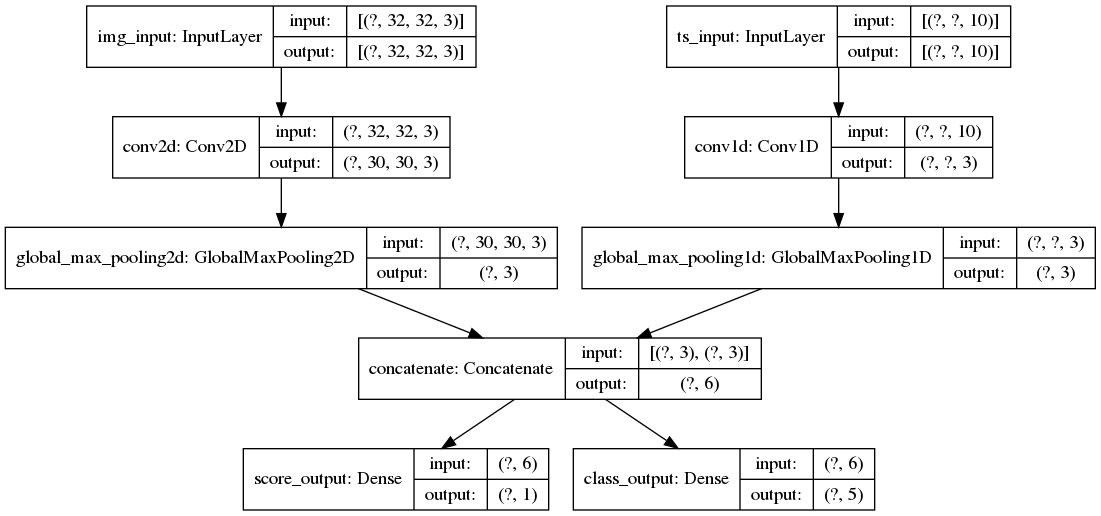

In [27]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])
keras.utils.plot_model(model, 'multi_input_output_model.png'
                       , show_shapes=True)

设置不同的loss和metric

In [28]:
# 可以为模型指定不同的loss和metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# 还可以指定loss的权重
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weight={'score_output': 2., 'class_output': 1.})

# 可以把不需要传播的loss置0
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# 可以使用字典的方式设置
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})

W1011 16:45:08.059540 139768509077312 training_utils.py:1348] Output score_output missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to score_output.


为多输入和多输出模型构造numpy数据，并训练。

In [29]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# 生成数据
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# 训练
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)

# 可以使用字典匹配输入输出数据
model.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
          epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 1s 9ms/sample - loss: 9.0288 - score_output_loss: 2.9604 - class_output_loss: 5.3522
Epoch 2/3
100/100 [==============================] - 0s 249us/sample - loss: 7.4229 - score_output_loss: 2.1365 - class_output_loss: 5.3362
Epoch 3/3
100/100 [==============================] - 0s 201us/sample - loss: 6.5389 - score_output_loss: 1.3290 - class_output_loss: 4.9687
Train on 100 samples
Epoch 1/3
100/100 [==============================] - 0s 289us/sample - loss: 5.9722 - score_output_loss: 0.9410 - class_output_loss: 5.0048
Epoch 2/3
100/100 [==============================] - 0s 214us/sample - loss: 5.5640 - score_output_loss: 0.6367 - class_output_loss: 4.8433
Epoch 3/3
100/100 [==============================] - 0s 312us/sample - loss: 5.2626 - score_output_loss: 0.4297 - class_output_loss: 4.8506


使用Dataset构造数据。

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'img_input': img_data, 'ts_input': ts_data},
     {'score_output': score_targets, 'class_output': class_targets}))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=3)

Epoch 1/3
2/2 [==============================] - 0s 177ms/step - loss: 5.0879 - score_output_loss: 0.3531 - class_output_loss: 4.7348
Epoch 2/3
2/2 [==============================] - 0s 11ms/step - loss: 4.9957 - score_output_loss: 0.2925 - class_output_loss: 4.6843
Epoch 3/3
2/2 [==============================] - 0s 13ms/step - loss: 4.8919 - score_output_loss: 0.2547 - class_output_loss: 4.6686


## 6 使用回调
Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）与不同时间点调用的对象，可用于实现以下行为：

- 在训练期间的不同时间点进行验证（除了内置的按时间段验证）
- 定期检查模型是否超过某个精度阈值
- 在训练似乎停滞不前时，改变模型的学习率
- 在训练似乎停滞不前时，对顶层进行微调
- 在训练结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。

**可使用的内置回调有**

- ModelCheckpoint：定期保存模型。
- EarlyStopping：当训练不再改进验证指标时停止培训。
- TensorBoard：定期编写可在TensorBoard中显示的模型日志（更多细节见“可视化”）。
- CSVLogger：将丢失和指标数据流式传输到CSV文件。
- 等等

### 6.1 回调使用
下面是几个回调使用的简单例子

1）提前终止

In [31]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # 不再提升的关注指标
        monitor='val_loss',
        # 不再提升的阈值
        min_delta=1e-2,
        # 不再提升的轮次
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 2s 51us/sample - loss: 0.3631 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2154 - val_sparse_categorical_accuracy: 0.9335
Epoch 2/20
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1695 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.1844 - val_sparse_categorical_accuracy: 0.9447
Epoch 3/20
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1267 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.1592 - val_sparse_categorical_accuracy: 0.9519
Epoch 4/20
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1013 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.1440 - val_sparse_categorical_accuracy: 0.9594
Epoch 5/20
40000/40000 [==============================] - 1s 35us/sample - loss: 0.0837 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.1453 - val_sparse_categorical_accuracy: 0.9582
Epoch 6/20
4000

2）模型保存

In [32]:
# checkpoint模型回调
model = get_compiled_model()
check_callback = keras.callbacks.ModelCheckpoint(
    # 模型路径
    filepath='mymodel_{epoch}.h5',
    # 是否保存最佳
    save_best_only=True,
    # 监控指标
    monitor='val_loss',
    # 进度条类型
    verbose=1
)

model.fit(x_train, y_train,
         epochs=3,
         batch_size=64,
         callbacks=[check_callback],
         validation_split=0.2)



Train on 40000 samples, validate on 10000 samples
Epoch 1/3
38656/40000 [===========================>..] - ETA: 0s - loss: 0.3797 - sparse_categorical_accuracy: 0.8946
Epoch 00001: val_loss improved from inf to 0.24097, saving model to mymodel_1.h5
40000/40000 [==============================] - 2s 47us/sample - loss: 0.3731 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.2410 - val_sparse_categorical_accuracy: 0.9263
Epoch 2/3
39040/40000 [============================>.] - ETA: 0s - loss: 0.1717 - sparse_categorical_accuracy: 0.9493
Epoch 00002: val_loss improved from 0.24097 to 0.18096, saving model to mymodel_2.h5
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1713 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1810 - val_sparse_categorical_accuracy: 0.9459
Epoch 3/3
39680/40000 [============================>.] - ETA: 0s - loss: 0.1260 - sparse_categorical_accuracy: 0.9630
Epoch 00003: val_loss improved from 0.18096 to 0.15665, saving model to mymode

3）学习率调整

In [34]:
# 动态调整学习率
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    # 初始学习率
    initial_learning_rate,
    # 延迟步数
    decay_steps=10000,
    # 调整百分比
    decay_rate=0.96,
    staircase=True
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train,
         epochs=3,
         batch_size=64,
         callbacks=[check_callback],
         validation_split=0.2)


Train on 40000 samples, validate on 10000 samples
Epoch 1/3
39680/40000 [============================>.] - ETA: 0s - loss: 4.9481 - sparse_categorical_accuracy: 0.2915
Epoch 00001: val_loss did not improve from 0.15665
40000/40000 [==============================] - 2s 42us/sample - loss: 4.9245 - sparse_categorical_accuracy: 0.2911 - val_loss: 1.8496 - val_sparse_categorical_accuracy: 0.2757
Epoch 2/3
39680/40000 [============================>.] - ETA: 0s - loss: 1.7370 - sparse_categorical_accuracy: 0.3520
Epoch 00002: val_loss did not improve from 0.15665
40000/40000 [==============================] - 1s 35us/sample - loss: 1.7349 - sparse_categorical_accuracy: 0.3529 - val_loss: 1.9447 - val_sparse_categorical_accuracy: 0.3140
Epoch 3/3
38720/40000 [============================>.] - ETA: 0s - loss: 1.4804 - sparse_categorical_accuracy: 0.4632
Epoch 00003: val_loss did not improve from 0.15665
40000/40000 [==============================] - 1s 34us/sample - loss: 1.4759 - sparse_categ

4）训练可视化

In [36]:
# 使用tensorboard
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='./full_path_to_your_logs')
model = get_compiled_model()
model.fit(x_train, y_train,
         epochs=5,
         batch_size=64,
         callbacks=[tensorboard_cbk],
         validation_split=0.2)


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 2s 46us/sample - loss: 0.3759 - sparse_categorical_accuracy: 0.8946 - val_loss: 0.2314 - val_sparse_categorical_accuracy: 0.9332
Epoch 2/5
40000/40000 [==============================] - 1s 36us/sample - loss: 0.1778 - sparse_categorical_accuracy: 0.9472 - val_loss: 0.1941 - val_sparse_categorical_accuracy: 0.9389
Epoch 3/5
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1310 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.1643 - val_sparse_categorical_accuracy: 0.9503
Epoch 4/5
40000/40000 [==============================] - 1s 37us/sample - loss: 0.1026 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.1788 - val_sparse_categorical_accuracy: 0.9465
Epoch 5/5
40000/40000 [==============================] - 1s 36us/sample - loss: 0.0841 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.1470 - val_sparse_categorical_accuracy: 0.9581


###  6.2 创建自己的回调方法
构建一个可以记录每个epoch的loss的回调

In [37]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:',self.losses[-1])
        
model = get_compiled_model()

callbacks = [
    LossHistory()
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
38528/40000 [===========================>..] - ETA: 0s - loss: 0.3842 - sparse_categorical_accuracy: 0.8918
loss: 0.37819265995025636
40000/40000 [==============================] - 2s 42us/sample - loss: 0.3782 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.2499 - val_sparse_categorical_accuracy: 0.9256
Epoch 2/3
38720/40000 [============================>.] - ETA: 0s - loss: 0.1810 - sparse_categorical_accuracy: 0.9465
loss: 0.18032952436208724
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1803 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.1945 - val_sparse_categorical_accuracy: 0.9423
Epoch 3/3
38720/40000 [============================>.] - ETA: 0s - loss: 0.1307 - sparse_categorical_accuracy: 0.9608
loss: 0.13051214462518693
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1305 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.1679 - val_sparse_categorical_accurac

## 7 自己构造训练和验证循环

我们可以自定义循环和验证方法，而不是简单调用fit和evaluate()。

### 7.1使用GradientTape构建训练
GradientTape可以计算变量梯度，并实现反向传播的功能。我们下面使用GradientTape来构建自定义训练循环。

In [38]:
# 构建模型
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# 优化器和损失函数
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# 准备数据
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 自己构造循环
for epoch in range(3):
    print('epoch: ', epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # 开一个gradient tape, 计算梯度
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            # 获取loss
            loss_value = loss_fn(y_batch_train, logits)
            # 由loss计算各变量梯度
            grads = tape.gradient(loss_value, model.trainable_variables)
            # 使用优化器计算反向传播
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))
            

epoch:  0
Training loss (for one batch) at step 0: 2.3862709999084473
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.245845317840576
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.180447578430176
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.0862836837768555
Seen so far: 38464 samples
epoch:  1
Training loss (for one batch) at step 0: 2.0792737007141113
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.997469425201416
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.7244919538497925
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7059353590011597
Seen so far: 38464 samples
epoch:  2
Training loss (for one batch) at step 0: 1.6949570178985596
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5404092073440552
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.4513380527496338
Seen so far: 25664 samples
Training 

### 7.1 在自定义训练中设定指标
我们可以在自定义训练循环中随时使用内置指标（或编写的自定义指标）。流程如下：

- 在循环开始时实例化指标
- 每一批数据训练之后，调用metric.update_state()
- 需要获得指标时，调用metric.result()
- 需要清除指标时，调用metric.reset_states()

In [39]:
# 训练并验证

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# 实例化指标类.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy() 
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# 准备数据
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)


# 自定义训练迭代
for epoch in range(3):
    print('Start of epoch %d' % (epoch,))
  
    # 获取每一批数据。
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
        # 计算梯度， 反向传播
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 更新指标
        train_acc_metric(y_batch_train, logits)

        # 输出
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

    # 每一批次结束，获取一次指标
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    # 重置指标
    train_acc_metric.reset_states()

    # 迭代验证
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    # 获取验证指标
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.3234963417053223
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.1431407928466797
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.11155366897583
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.9793719053268433
Seen so far: 38464 samples
Training acc over epoch: 0.3366200029850006
Validation acc: 0.5264999866485596
Start of epoch 1
Training loss (for one batch) at step 0: 2.0552053451538086
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9160033464431763
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.797502040863037
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.626814842224121
Seen so far: 38464 samples
Training acc over epoch: 0.589959979057312
Validation acc: 0.6836000084877014
Start of epoch 2
Training loss (for one batch) at step 0: 1.6038627624511719
Seen so far: 64 samples
Training l

### 7.2 在自定义训练中添加loss

我们可以在自定义训练中添加自定义损失。

In [40]:
##　添加自己构造的loss, 每次只能看到最新一次训练增加的loss
class ActivityRegularizationLayer(layers.Layer):
  
  def call(self, inputs):
    self.add_loss(1e-2 * tf.reduce_sum(inputs))
    return inputs
  
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# 添加正则化损失层
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)


[<tf.Tensor: id=651125, shape=(), dtype=float32, numpy=7.207233>]
[<tf.Tensor: id=651185, shape=(), dtype=float32, numpy=6.9617286>]


In [42]:
# 将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)

            # 添加额外的损失
            loss_value += sum(model.losses)
        # 求梯度，反向传播
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 输出
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 2.320131778717041
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3046109676361084
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.309241771697998
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3098361492156982
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3076140880584717
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.307394504547119
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3062784671783447
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3098881244659424
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.3012585639953613
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3015058040618896
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3131601810455322
Seen so far: 25